In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

In [3]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

DEBUG:CONFIGDIR=/home/cweniger/.config/matplotlib
DEBUG:(private) matplotlib data path: /home/cweniger/.local/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib data path: /home/cweniger/.local/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:loaded rc file /home/cweniger/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib version 3.2.1
DEBUG:interactive is False
DEBUG:platform is linux
DEBUG:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machine

In [4]:
DEVICE = 'cuda'

In [5]:
def model(v):
    a = v[0]
    b = v[1]
    r = (a**2+b**2)**0.5
    x=np.array([r])
    return dict(mu=x)

def noise(obs, v, noise = 0.001):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

In [6]:
v0 = np.array([0.3, 0.1])
obs0 = model(v0)
obs0

{'mu': array([0.31622777])}

In [7]:
simulator = swyft.Simulator(model, sim_shapes = {"mu": (1,)})
prior = swyft.Prior.from_uv(lambda u: u*2-1, 2)

In [8]:
store = swyft.MemoryStore(['z0', 'z1'], simulator = simulator)

DEBUG:Creating new empty MemoryStore.
DEBUG:  params = ['z0', 'z1']
INFO:Creating new store.
DEBUG:  sim_shapes = {'mu': (1,)}


In [18]:
partition = ((0, 1,),)
bound = None
for N in [1000]:
    print(N)
    task = swyft.Task(N, prior, store, simhook = noise, bound = bound)
    task.dataset.simulate()
    task.posteriors.add(partition)
    task.posteriors.train(partition)
    bound = task.truncate(partition, obs0)
    print(bound.volume)

1000


DEBUG:No simulations required.
DEBUG:Initializing swyft.Module with tag `DefaultHead`
DEBUG:  args = `()`
DEBUG:  kwargs = `{'obs_shapes': {'x': torch.Size([1])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:Initializing swyft.Module with tag `DefaultTail`
DEBUG:  args = `(1, [(0, 1)])`
DEBUG:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:Entering trainloop
DEBUG:  combinations = None
DEBUG:  batch_size = 32
DEBUG:  nworkers = 0
DEBUG:  max_epochs = 10
DEBUG:  early_stopping_patience = 1
DEBUG:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:  percent_validation = 0
DEBUG:lr: 0.001
DEBUG:validation loss = 1.366
DEBUG:validation loss = 1.254
DEBUG:validation loss = 1.03
DEBUG:validation loss = 0.8987
DEBUG:validation loss = 0.8079
DEBUG:validation loss = 0.686
DEBUG:validation loss = 0.5698
DEBUG:validation loss = 0.4959
DEBUG:validation loss = 0.4315
DEBUG:validation loss = 0

0.22218180370104243


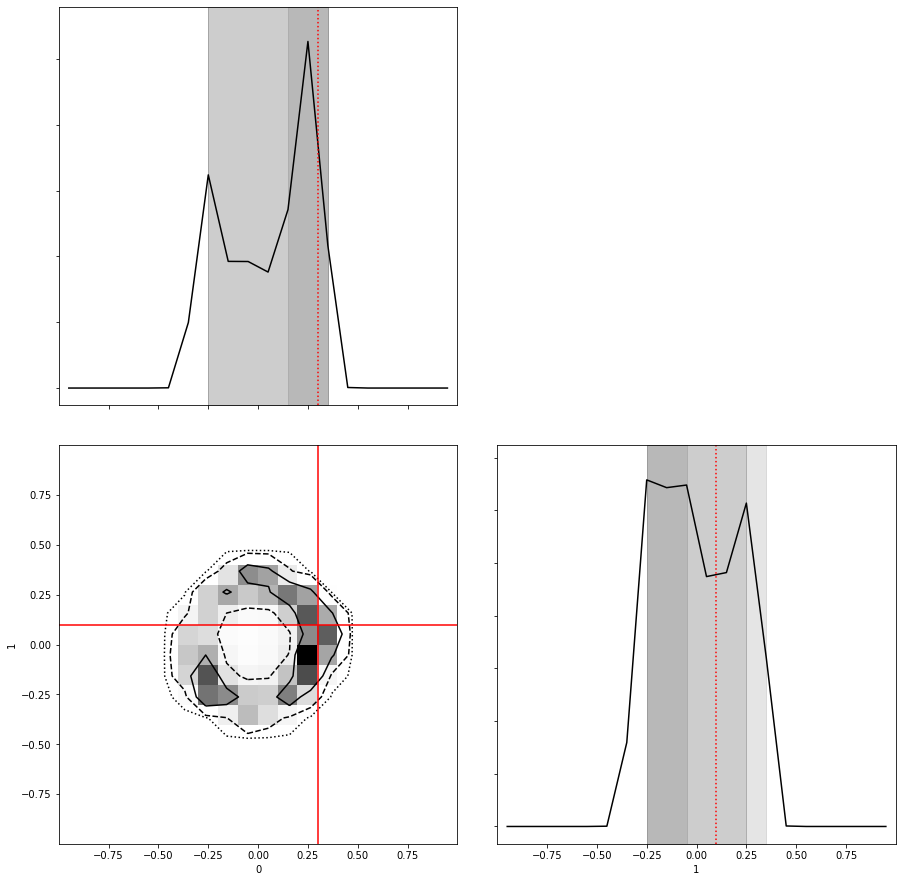

In [19]:
samples = task.posteriors.sample(10000, obs0)
swyft.corner(samples, [0, 1], color='k', figsize = (15,15), truth=v0, bins = 20)

In [ ]:
z = task.dataset.pars
plt.scatter(z[:,0], z[:,1])

In [12]:
task.posteriors.train(partition)

In [15]:
-np.log(0.5)*4

2.772588722239781

In [17]:
partition

(0, 1)